# 6章 学習に関するテクニック

In [1]:
import numpy as np

# 確率的勾配降下法（Stochastic Gradient Descent）
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

# モーメンタム（Momentum）：運動量
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

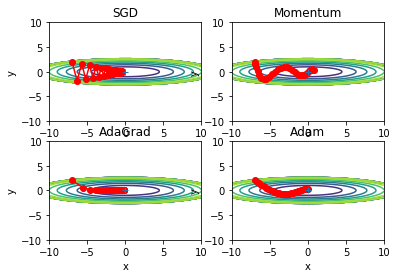

In [2]:
import sys, os
sys.path.append(os.pardir)
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import Adam

def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

===========iteration:0===========
SGD:2.4087052032290783
Momentum:2.6614337389484257
AdaGrad:2.094458132747921
Adam:2.1991493306016325
===========iteration:100===========
SGD:1.6079072887783323
Momentum:0.31347591706608147
AdaGrad:0.14260979349676378
Adam:0.24116234159475042
===========iteration:200===========
SGD:0.7840945460115746
Momentum:0.21517556055474515
AdaGrad:0.09776116632636875
Adam:0.16419379823650926
===========iteration:300===========
SGD:0.5434675953492011
Momentum:0.20798916797051178
AdaGrad:0.12257072731280416
Adam:0.17454260756585505
===========iteration:400===========
SGD:0.49446284831131726
Momentum:0.27787452332958745
AdaGrad:0.09843221306357358
Adam:0.2058722951702216
===========iteration:500===========
SGD:0.3271872764392745
Momentum:0.15990759531705998
AdaGrad:0.05974742697318233
Adam:0.11546498109585954
===========iteration:600===========
SGD:0.43198612744411385
Momentum:0.1560612570002083
AdaGrad:0.05251374274001844
Adam:0.10755842578317701
===========iteratio

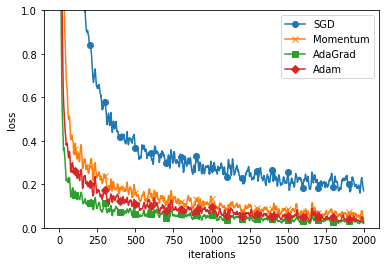

In [3]:
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

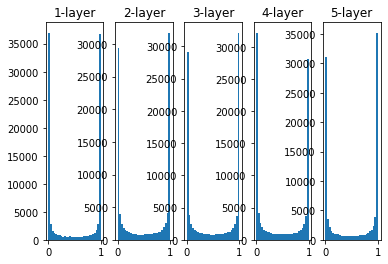

In [25]:
# 隠れ層のアクティベーション（活性化関数の後の出力データ）分布

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

x = np.random.randn(1000, 100) # 1000個のデータ
node_num = 100 # 各隠れ層のノード（ニューロンの数）
hidden_layer_size = 5 # 隠れ層が5層
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    z = np.dot(x, w)
    a = sigmoid(z) # シグモイド関数！
    # a = ReLU(z)
    # a = tanh(z)
    activations[i] = a

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))

===========iteration:0===========
std=0.01:2.3024800405998564
Xavier:2.296690156723568
He:2.3471670183139524
===========iteration:100===========
std=0.01:2.3029736858715157
Xavier:2.2625095685005783
He:1.66574754843214
===========iteration:200===========
std=0.01:2.302390538744672
Xavier:2.1928212099162074
He:0.8425840691197857
===========iteration:300===========
std=0.01:2.302523982810974
Xavier:1.9722137696044588
He:0.6275011554265691
===========iteration:400===========
std=0.01:2.3027415603420796
Xavier:1.479078878825618
He:0.3642823924971973
===========iteration:500===========
std=0.01:2.3032086490104007
Xavier:0.9924108381324586
He:0.3668542311113556
===========iteration:600===========
std=0.01:2.3006997468776547
Xavier:0.6987079719972928
He:0.2620879723454558
===========iteration:700===========
std=0.01:2.298482348932189
Xavier:0.6670420454317914
He:0.41570777900312894
===========iteration:800===========
std=0.01:2.3038473137709587
Xavier:0.5608119948135414
He:0.3620504840879761


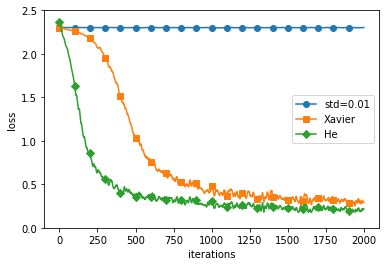

In [4]:
# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

============== 1/16 ==============
epoch:0 | 0.116 - 0.05
epoch:1 | 0.097 - 0.064
epoch:2 | 0.097 - 0.076
epoch:3 | 0.097 - 0.101
epoch:4 | 0.097 - 0.12
epoch:5 | 0.097 - 0.127
epoch:6 | 0.097 - 0.139
epoch:7 | 0.097 - 0.149
epoch:8 | 0.097 - 0.166
epoch:9 | 0.097 - 0.18
epoch:10 | 0.097 - 0.19
epoch:11 | 0.097 - 0.215
epoch:12 | 0.097 - 0.244
epoch:13 | 0.097 - 0.261
epoch:14 | 0.097 - 0.275
epoch:15 | 0.097 - 0.283
epoch:16 | 0.097 - 0.3
epoch:17 | 0.097 - 0.304
No handles with labels found to put in legend.
epoch:18 | 0.097 - 0.332
epoch:19 | 0.097 - 0.343
============== 2/16 ==============
epoch:0 | 0.099 - 0.093
epoch:1 | 0.097 - 0.084
epoch:2 | 0.097 - 0.092
epoch:3 | 0.097 - 0.121
epoch:4 | 0.097 - 0.145
epoch:5 | 0.097 - 0.169
epoch:6 | 0.097 - 0.189
epoch:7 | 0.097 - 0.216
epoch:8 | 0.097 - 0.254
epoch:9 | 0.097 - 0.268
epoch:10 | 0.097 - 0.298
epoch:11 | 0.097 - 0.321
epoch:12 | 0.097 - 0.348
epoch:13 | 0.097 - 0.373
epoch:14 | 0.097 - 0.389
epoch:15 | 0.097 - 0.401
epoch:16 

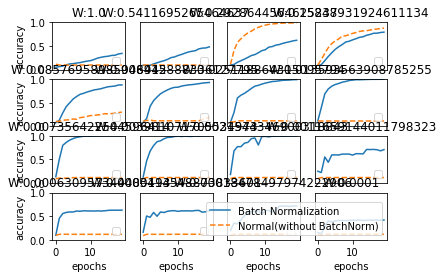

In [6]:
from common.multi_layer_net_extend import MultiLayerNetExtend

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.グラフの描画==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

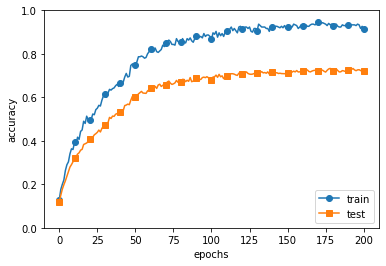

In [9]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10, weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 学習係数0.01のSGDでパラメータ更新

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [10]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flag=True):
        if train_flag:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
    
    def backward(self, dout):
        return dout * self.mask

train loss:2.309839452350806
=== epoch:1, train acc:0.1, test acc:0.1019 ===
train loss:2.325723151878864
train loss:2.3142159469027415
train loss:2.3040764818268284
=== epoch:2, train acc:0.1, test acc:0.102 ===
train loss:2.307855540535165
train loss:2.3064867159822384
train loss:2.3189949946276314
=== epoch:3, train acc:0.09666666666666666, test acc:0.1025 ===
train loss:2.290944207877097
train loss:2.278484389847106
train loss:2.326032796734998
=== epoch:4, train acc:0.1, test acc:0.1048 ===
train loss:2.30441369468879
train loss:2.3241877333197785
train loss:2.307274029868864
=== epoch:5, train acc:0.10333333333333333, test acc:0.1051 ===
train loss:2.300185732556697
train loss:2.2854875674829955
train loss:2.307341647832305
=== epoch:6, train acc:0.10666666666666667, test acc:0.1063 ===
train loss:2.3039164047651735
train loss:2.287934927699566
train loss:2.298997591089381
=== epoch:7, train acc:0.10666666666666667, test acc:0.1081 ===
train loss:2.2885385034417687
train loss:2.3

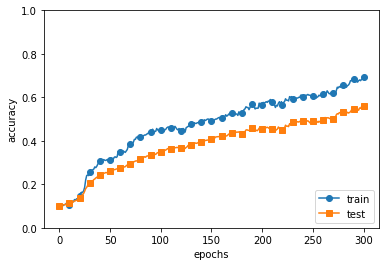

In [11]:
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.84) | lr:0.009916444188342283, weight decay:8.234770711649163e-06
Best-2(val acc:0.83) | lr:0.00829939698958521, weight decay:1.4786331044502653e-06
Best-3(val acc:0.82) | lr:0.007548977568936618, weight decay:2.820814635707981e-05
Best-4(val acc:0.81) | lr:0.006191940458717099, weight decay:1.884551577970296e-06
Best-5(val acc:0.78) | lr:0.006815975448774833, weight decay:2.9695356784990226e-07
Best-6(val acc:0.77) | lr:0.009223336677432862, weight decay:5.8482991631605144e-06
Best-7(val acc:0.76) | lr:0.007201205901775031, weight decay:3.23030094989524e-06
Best-8(val acc:0.76) | lr:0.00786686260385412, weight decay:1.4799549414114827e-05
Best-9(val acc:0.72) | lr:0.0058393068822000125, weight decay:2.5877358658111084e-07
Best-10(val acc:0.68) | lr:0.004737296575378714, weight decay:1.630984121264597e-08
Best-11(val acc:0.64) | lr:0.004773121911739191, weight decay:5.7645799799033007e-05
Best-12(val acc:0.62)

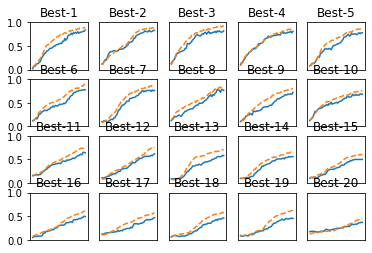

In [13]:
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()